# Proyecto Control Optimo
## Resonancia Magnetica

Diego Echeverria
Luciano Ragebait


# HOLA LUCIANO

In [1]:
import Pkg
Pkg.add("JuMP")
Pkg.add("Ipopt")
Pkg.add("Plots")
Pkg.add("OptimalControl")
Pkg.add("DifferentialEquations")

    Updating registry at `C:\Users\Diego\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\Diego\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\Diego\.julia\environments\v1.11\Manifest.toml`
Precompiling project...
           ✗ BARON
  0 dependencies successfully precompiled in 137 seconds. 570 already precompiled.

The following 1 direct dependency failed to precompile:

BARON 

Failed to precompile BARON [2e2ca445-9e14-5b13-8677-4410f177f82b] to "C:\\Users\\Diego\\.julia\\compiled\\v1.11\\BARON\\jl_BDC6.tmp".
ERROR: LoadError: SystemError: opening file "C:\\Users\\Diego\\.julia\\packages\\BARON\\rvhNu\\deps\\path.jl": No such file or directory
Stacktrace:
  [1] systemerror(p::String, errno::Int32; extrainfo::Nothing)
    @ Base .\error.jl:176
  [2] systemerror
    @ .\error.jl:175 [inlined]
  [3] open(fname::String; lock::Bool, read::Bool, write::Nothing, create::Nothing, truncate::Nothing, append::Nothing)
    @ Base .\iost

Para Partir
Tenemos dos vectores metidos en la bola
el control esta en la bola
cada vector tiene hiperparametros distintos
el control se mueve inponiendo que q1 termine en el 0


$$  
    max \space |q_2(t_f)|^2
$$
$$
 \dot q = F(q,u)
$$
$$
    |u(-)| \leq 1
$$
$$
q_1(0) = q_2(0) = (0,1)
$$
$$
q_1(t_f) = (0,0)
$$

In [2]:
using JuMP
import Ipopt
using Plots
using LinearAlgebra

# Modelacion JuMP con EULER
function Euler_magnetic(N,v1,v2,tf,q10,q20)

    # N: Numero de pasos
    # v1: Hiperparametros de q1  ( es q)
    # v2: Hiperparametros de q2 ( es r) 
    # tf: tiempo final escogido ( múltiplo de tiempo minimo de convergencia de q1)
    model = JuMP.Model(Ipopt.Optimizer)
    set_silent(model)
    @variable(model, q[1:2,1:N+1]) # variable q1
    @variable(model, r[1:2,1:N+1]) # variable q2
    @variable(model, 1 >= u[1:N+1] >= -1) # el control 

    y10,z10 = q10
    y20,z20 = q20
    
    @constraint(model, q[:,1] == [y10,z10]) # cond ini q1
    @constraint(model, r[:,1] == [y20,z20]) # cond ini q2

    @constraint(model, q[: ,N+1] == [0,0]) # cond final de q1

    sigma1, gamma1 = v1
    sigma2, gamma2 = v2

    A1 = [-sigma1 0 ; 0 -gamma1]
    C1 = [0 , gamma1]
    @constraint(model, [i = 1:N], q[:,i+1] == q[:,i] + (tf/N) .* (A1*q[:,1] + [ -q[2,i]*u[i] , q[1,i]*u[i] ] + C1)) # paso de q1

    A2 = [-sigma2 0 ; 0 -gamma2]
    C2 = [0 , gamma2]
    @constraint(model, [i = 1:N], r[:,i+1] == r[:,i] + (tf/N) .* (A2*r[:,1] +[ -r[2,i]*u[i] , r[1,i]*u[i] ] + C2)) # paso de q2

    @objective(model, Max, sum(r[:,N+1].^2) )
    optimize!(model);

    println("Valor final en norma: ", string( sum(value(r[:,N+1]).^2) ))
    u = [value(u[i]) for i in 1:N+1]
    q1 =[value(q[:,i]) for i in 1:N+1]
    q2 =[value(r[:,i]) for i in 1:N+1]
    t = range(0,tf, N+1)

end
    

Euler_magnetic (generic function with 1 method)

In [3]:
using OptimalControl
using NLPModelsIpopt

# busco el tiempo minimo de convergencia de q1 para tener el rango de tiempo del problema completo
function find_tmin(v1,q0)
    

sigma1, gamma1 = v1
y0,z0 = q0
OCP = @def begin
        tf ∈ R, variable
        t ∈ [0,tf], time
        q1 = (y,z) ∈ R^2, state
        u ∈ R, control

        # restricciones tiempo y control
        tf >= 0.001 # pa que no de negativo
        -1 <= u(t) <= 1

        # condiciones iniciales
        y(0) == y0
        z(0) == z0

        # condiciones finales
        y(tf) == 0
        z(tf) == 0

        # ecuaciones 
        ∂(y)(t) == -sigma1*y(t) -u(t)*z(t)
        ∂(z)(t) == gamma1*(1-z(t)) + u(t)*y(t)

        tf → min

    end

    sol_ocp = solve(OCP, display=false)
    println("Tiempo optimo: ", sol_ocp.objective)
    plot(sol_ocp,plot_title = "Control y trayectoria optima de la particula" )

    return sol_ocp.objective
end 

find_tmin (generic function with 1 method)

In [4]:
v1 = [ 1/0.3, 1/2 ]
v2 = [ 1/2.5, 1/2.5]

q01 = [0.5,0.5]

# tiempo
tf = find_tmin(v1,q01)

print(tf)
N = 100
# debo escoger un multiplo del tiempo
Euler_magnetic(N,v1,v2,10*tf,q01,q01)


Tiempo optimo: 0.8178531423147481
0.8178531423147481Valor final en norma: 0.7347118868650582


0.0:0.08178531423147481:8.178531423147481

In [5]:
using OptimalControl
using NLPModelsIpopt
using Plots

# Misma modelacion pero en OptimalControl 
function OC_Magnetic(v1,v2,tf,q10,q20)

sigma1, gamma1 = v1
sigma2, gamma2 = v2
y10,z10  = q10
y20,z20 = q20

OCP = @def begin
        t ∈ [0,tf], time
        q = (y1,z1,y2,z2) ∈ R^4, state
        u ∈ R, control



        0 <= u(t) <= 1

        # condiciones iniciales
        y1(0) == y10
        z1(0) == z10
        y2(0) == y20
        z2(0) == z20

        # condiciones finales
        y1(tf) == 0.0
        z1(tf) == 0.0

        # ecuaciones 
        ∂(y1)(t) == -sigma1*y1(t) -u(t)*z1(t)
        ∂(z1)(t) == gamma1*(1-z1(t)) + u(t)*y1(t)
        
        ∂(y2)(t) == -sigma2*y2(t) -u(t)*z2(t)
        ∂(z2)(t) == gamma2*(1-z2(t)) + u(t)*y2(t)

        y2(tf)^2 + z2(tf)^2  → max

        
     end

    sol_ocp = solve(OCP, display=false)
    println("Tiempo optimo: ", sol_ocp.objective)
    plot(sol_ocp,plot_title = "Control y trayectoria optima de la particula" )
     println("Valor máximo de ||q2||: ", sqrt(sol_ocp.objective))

    step = tf/100
    time_grid = 0.0:step:tf # Example time grid
    qq = state(sol_ocp)
  
    println("SEMEN")
    y1_data = [qq(t)[1] for t in time_grid]
    z1_data = [qq(t)[2] for t in time_grid]
    y2_data = [qq(t)[3] for t in time_grid]
    z2_data = [qq(t)[4] for t in time_grid]

    print( qq(tf), "Valores Finales")

# --- Creación del Gráfico Combinado ---
    
    # --- Gráfico 1: Trayectoria de q1 (con flechas) ---
    plot_q1 = plot(
        xlabel="y (Plano Transversal)", 
        ylabel="z (Plano Longitudinal)",
        title="Trayectoria de q1 (Tejido 1)",
        legend=:topleft,
        aspect_ratio=:equal
    )

    # Añadir trayectoria de q1 con FLECHAS
    plot!(plot_q1, y1_data, z1_data, 
        label="q1", 
        lw=2, 
        color=:blue,
    )

    # Marcar puntos de q1
    scatter!(plot_q1, [y1_data[1]], [z1_data[1]], 
        label="Inicio", color=:green, markersize=5)
    scatter!(plot_q1, [y1_data[end]], [z1_data[end]], 
        label="Fin q1 (0,0)", color=:blue, marker=:x, markersize=5,arrow=true)


    plot_q2 = plot(
        xlabel="y (Plano Transversal)", 
        ylabel="z (Plano Longitudinal)",
        title="Trayectoria de q2 (Tejido 2)",
        legend=:topleft,
        aspect_ratio=:equal
    )

    # Añadir trayectoria de q2 con FLECHAS
    plot!(plot_q2, y2_data, z2_data, 
        label="q2", 
        lw=2, 
        color=:red
    )

    # Marcar puntos de q2
    scatter!(plot_q2, [y2_data[1]], [z2_data[1]], 
        label="Inicio", color=:green, markersize=5)
    scatter!(plot_q2, [y2_data[end]], [z2_data[end]], 
        label="Fin q2 (Max)", color=:red, marker=:star, markersize=5)

    # --- Gráfico 1: Control (AÑADIDO) ---
    plot_control = plot(sol_ocp, :control, 
        title="Control Óptimo u(t)", 
        label="u(t)", 
        lw=2
    )

    # --- Combinar y Mostrar ---
    # Crea un gráfico final con los dos sub-gráficos
    combined_plot = plot(plot_q1, plot_q2, layout=(1,2), size=(800, 500))
    
    display(combined_plot)

    display(plot_control)
    #savefig(combined_plot, "trayectorias_separadas_con_flechas.png")
    savefig(plot_control, "control_óptimo.png")
    println("Gráfico combinado guardado como 'trayectorias_separadas_con_flechas.png'")

end

        

OC_Magnetic (generic function with 1 method)

Tiempo optimo: 0.0009999916853262437
0.0019999833706524873Tiempo optimo: 0.999999999997017
Valor máximo de ||q2||: 0.9999999999985085
SEMEN
[-7.324874592996607e-12, 1.7406616505233512e-8, -0.0006797571503085786, 0.9999997689635901]Valores FinalesGráfico combinado guardado como 'trayectorias_separadas_con_flechas.png'


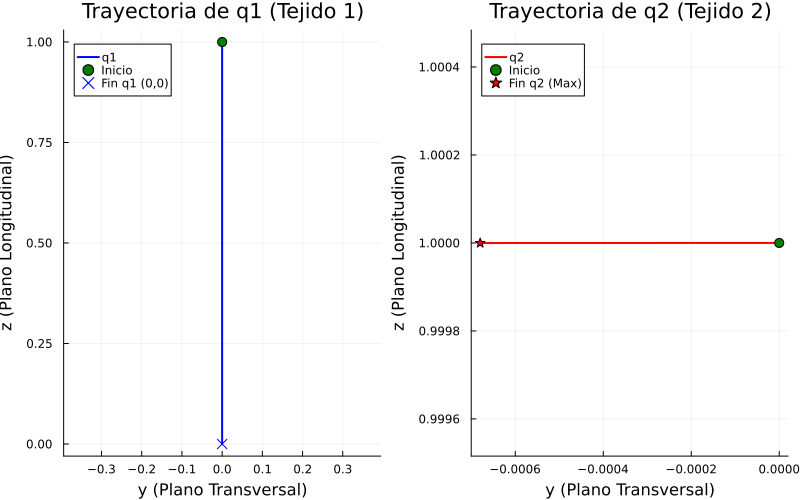

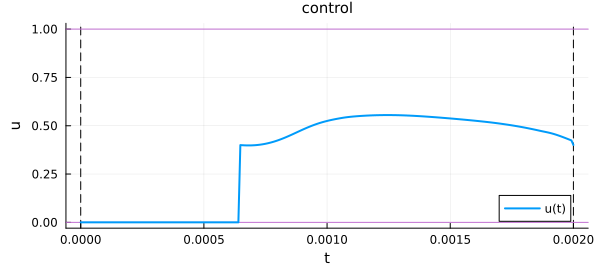

In [6]:
w = 2*pi*32
v1 = [ 1/(0.3*w), 1/(2*w) ]
v2 = [ 1/(2.5*w), 1/(2.5*w)] # esto quizas falta un 2pi

q10 = [0,1]

tf = find_tmin(v1,q10)
tf = 2*tf
print(tf)
OC_Magnetic(v1,v2,tf,q10,q10)

In [7]:
# Modelacion JuMP con EULER
function Euler_magnetic3D(N,v1,v2,tf)

    # N: Numero de pasos
    # v1: Hiperparametros de q1  ( es q)
    # v2: Hiperparametros de q2 ( es r) 
    # tf: tiempo final escogido ( múltiplo de tiempo minimo de convergencia de q1)
    model = JuMP.Model(Ipopt.Optimizer)
    set_silent(model)
    @variable(model, q[1:3,1:N+1]) # variable q1 (x,y,z)
    @variable(model, r[1:3,1:N+1]) # variable q2 (x,y,z)
    @variable(model, 1 >= u[1:2,1:N+1] >= -1) # el control 
    
    @constraint(model, q[:,1] == [0,0,1]) # cond ini q1
    @constraint(model, r[:,1] == [0,0,1]) # cond ini q2

    @constraint(model, q[: ,N+1] == [0,0,0]) # cond final de q1

    @constraint(model, [i = 1:N], u[1,i]^2+u[2,i]^2 <= 1 ) # control en bola unitaria

    sigma1, gamma1 = v1
    sigma2, gamma2 = v2

    A1 = [-sigma1 0 0; 0 -sigma1 0 ; 0 0 -gamma1]
    C1 = [0, 0 , gamma1]
    @constraint(model, [i = 1:N], q[:,i+1] == q[:,i] + (tf/N) .* (A1*q[:,1] + [ q[3,i]*u[2,i], -q[3,i]*u[1,i] , q[2,i]*u[1,i] - q[1,i]*u[2,i] ] + C1)) # paso de q1

    A2 = [-sigma2 0 0; 0 -sigma2 0 ; 0 0 -gamma2]
    C2 = [0 ,0, gamma2]
    @constraint(model, [i = 1:N], r[:,i+1] == r[:,i] + (tf/N) .* (A2*r[:,1] + [ r[3,i]*u[2,i], -r[3,i]*u[1,i] , r[2,i]*u[1,i] - r[1,i]*u[2,i] ] + C2)) # paso de q2

    @objective(model, Max, sum(r[:,N+1].^2) )
    optimize!(model);

    println("Valor final en norma: ", string( sum(value(r[:,N+1]).^2) ))
    # u = [value(u[i]) for i in 1:N+1]
    # q1 =[value(q[:,i]) for i in 1:N+1]
    # q2 =[value(r[:,i]) for i in 1:N+1]
    # t = range(0,tf, N+1)

end

Euler_magnetic3D (generic function with 1 method)

In [8]:
using OptimalControl
using NLPModelsIpopt

# busco el tiempo minimo de convergencia de q1 para tener el rango de tiempo del problema completo
function find_tmin3D(v1)
    

sigma1, gamma1 = v1
OCP = @def begin
        tf ∈ R, variable
        t ∈ [0,tf], time
        q1 = (x,y,z) ∈ R^3, state
        u = (u1,u2) ∈ R^2, control

        # restricciones tiempo y control
        tf >= 0.001 # pa que no de negativo
        -1 <= sum(u1(t)^2 + u2(t)^2) <= 1

        # condiciones iniciales
        x(0) == 0
        y(0) == 0
        z(0) == 1

        # condiciones finales
        x(tf) == 0
        y(tf) == 0
        z(tf) == 0
        

        # ecuaciones
        ∂(x)(t) == -sigma1*x(t) - u2(t)*z(t)
        ∂(y)(t) == -sigma1*y(t) -u1(t)*z(t)
        ∂(z)(t) == gamma1*(1-z(t)) + u1(t)*y(t) - u2(t)*x(t)

        tf → min

    end

    sol_ocp = solve(OCP, display=false)
    println("Tiempo optimo: ", sol_ocp.objective)
    plot(sol_ocp,plot_title = "Control y trayectoria optima de la particula" )

    return sol_ocp.objective
end 

find_tmin3D (generic function with 1 method)

In [9]:
using OptimalControl
using NLPModelsIpopt

# Misma modelacion pero en OptimalControl 
function OC_Magnetic3D(v1,v2,tf)

sigma1, gamma1 = v1
sigma2, gamma2 = v2

OCP = @def begin
        t ∈ [0,tf], time
        q = (x1,y1,z1,x2,y2,z2) ∈ R^6, state
        u = (u1,u2) ∈ R^2, control


        # restricciones tiempo y control
        tf >= 0.001 # pa que no de negativo
        -1 <= sum(u1(t)^2 + u2(t)^2) <= 1

        # condiciones iniciales
        x1(0) == 0
        y1(0) == 0
        z1(0) == 1

        x2(0) == 0
        y2(0) == 0
        z2(0) == 1

        # condiciones finales
        x1(tf) == 0
        y1(tf) == 0
        z1(tf) == 0

        # ecuaciones
        ∂(x1)(t) == -sigma1*x1(t) - u2(t)*z1(t)
        ∂(y1)(t) == -sigma1*y1(t) -u1(t)*z1(t)
        ∂(z1)(t) == gamma1*(1-z1(t)) + u1(t)*y1(t) - u2(t)*x(t)
        
        ∂(x2)(t) == -sigma2*x2(t) - u2(t)*z2(t)
        ∂(y2)(t) == -sigma2*y2(t) -u1(t)*z2(t)
        ∂(z2)(t) == gamma2*(1-z2(t)) + u1(t)*y2(t) - u2(t)*x2(t)

        x2(tf)^2 + y2(tf)^2 + z2(tf)^2  → max

        
     end

    sol_ocp = solve(OCP, display=false)
    println("Tiempo optimo: ", sol_ocp.objective)
    plot(sol_ocp,plot_title = "Control y trayectoria optima de la particula" )

    a = plot(sol_ocp, :control, title="Mi Gráfico de Control")

    # b = plot(sol_ocp, :state, x=:y1, y=:z1, title="Plano de Fase (z1 vs y1)", label="Trayectoria")
    display(a)
    #display(b)
end 
        

OC_Magnetic3D (generic function with 1 method)

In [10]:
w = 2*pi*32
v1 = [ 1/(0.3*w), 1/(2*w) ]
v2 = [ 1/(2.5*w), 1/(2.5*w)] # esto quizas falta un 2pi


# tiempo
tf = find_tmin(v1)

print(tf)
N = 100
# debo escoger un multiplo del tiempo
Euler_magnetic3D(N,v1,v2,10*tf)


MethodError: MethodError: no method matching find_tmin(::Vector{Float64})
The function `find_tmin` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  find_tmin(::Any, !Matched::Any)
   @ Main c:\Users\Diego\OneDrive\Escritorio\Universidad\Semestre 12\Control optimo\Proyecto Resonancia Magnetica\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:5


In [11]:
w = 2*pi*32
v1 = [ 1/(0.3*w), 1/(2*w) ]
v2 = [ 1/(2.5*w), 1/(2.5*w)] # esto quizas falta un 2pi

tf = find_tmin3D(v1)

print(tf)
OC_Magnetic3D(v1,v2,20*tf)

Tiempo optimo: 155.55013067964626
155.55013067964626

UndefVarError: UndefVarError: `x` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

# Debido a la ecuación no lineal de la función objectivo (problema de mayer) se va a hacer la función P


$$
g(q(t_f)) = |q_2(t_f)|^2
$$

$$
H(q,u,\lambda) = \lambda^T F(q,u)
$$

$$
H(t,x,p(t),u(t)) = p(t)^T F(x(t),u(t)) \\
= p_{y_1}(t) (\Gamma_{1} y_1(t) - u z_1(t)) + p_{z_1}(t) (\gamma_{1} (1-z_1(t)) + u y_1(t)) \\
+ p_{y_2}(t) (\Gamma_{2} y_2(t) - u z_2(t)) + p_{z_2}(t) (\gamma_{2}(1-z_2(t)) + u y_2(t))  
$$


Veamos las condiciones de transversalidad

$$
0 = p_0 dg + [\theta(t)dt - p(t)^T dx_t]_{dt_0}^{dt_f} 
$$

Veamos que variable son libres y cuales no
- t0 fijo = 0
- tf es fijo = $\lambda T_{min}$
- x0 fijo = $(0,1,0,1)$
- xf libre $(0,0,y_2(t_f),z_2(t_f))$

Con esto dg es 
$$
dg = [0,0,0,2y_2(t_f)+2z_2(t_f)]^T
$$

In [12]:
function optimal_u(t,q,p)
    u = -p[1]*q[2] + p[2]*q[1] - p[3]*q[4]  + p[4]*q[3]
    return u
end

optimal_u (generic function with 1 method)

In [13]:
# cons = [gamma1, sigma1, gamma2, sigma2]
function system_acoplado!(t,q,p,cons)
    u = optimal_u(t,q,p)

    gamma1, sigma1, gamma2, sigma2 = cons

    dq = [0,0,0,0]
    dp = [0,0,0,0]
    dq[1] = -gamma1*q[1] - u*q[2]
    dq[2] = sigma1*(1-q[2]) + u*q[1]
    dq[3] = -gamma2*q[3] - u*q[4]
    dq[4] = sigma2*(1-q[4]) + u*q[3]
    
    dp[1] = gamma1*p[1] - u*p[2]
    dp[2] = p[2]*sigma1 + u*p[1]
    dp[3] = gamma2*p[3] - u*p[4]
    dp[4] = +p[4]*sigma2 + u*p[3]

    return dq, dp
end

system_acoplado! (generic function with 1 method)

In [14]:
using JuMP
using Ipopt
import DifferentialEquations as DE
using LinearAlgebra

# --- FUNCIÓN 1: Tu optimal_u (Está perfecta) ---
# Recibe (t, q_states, p_states)
function optimal_u(t,q,p)
    cosa = -p[1]*q[2] + p[2]*q[1] - p[3]*q[4]  + p[4]*q[3]
    if cosa >= 0
        u = 0
    else
        u = 1
    end
    return u
end

# --- FUNCIÓN 2: system_acoplado! (Corregida) ---
# Argumentos: (t, p_states, q_states, cons)
function system_acoplado!(t, p, q, cons)
    
    # ARREGLO 1: Llamar a optimal_u con los argumentos correctos (t, q, p)
    u = optimal_u(t, q, p) 

    gamma1, sigma1, gamma2, sigma2 = cons

    # ARREGLO 2: Inicializar 'dq' y 'dp' con el tipo de entrada
    T = eltype(q) 
    dq = zeros(T, 4)
    dp = zeros(T, 4)
    
    dq[1] = -gamma1*q[1] - u*q[2]
    dq[2] = sigma1*(1-q[2]) + u*q[1]
    dq[3] = -gamma2*q[3] - u*q[4]
    dq[4] = sigma2*(1-q[4]) + u*q[3]
    
    dp[1] = gamma1*p[1] - u*p[2]
    dp[2] = p[2]*sigma1 + u*p[1]
    dp[3] = gamma2*p[3] - u*p[4]
    dp[4] = p[4]*sigma2 + u*p[3]

    return dq, dp
end

function EDO!(du, u, p, t)
    
    # ARREGLO 3: Llamar a system_acoplado!
    # u[5:8] son los p_states
    # u[1:4] son los q_states
    # p       son los cons
    dq, dp = system_acoplado!(t, u[5:8], u[1:4], p) 
    
    du[1] = dq[1]
    du[2] = dq[2]
    du[3] = dq[3]
    du[4] = dq[4]
    du[5] = dp[1]
    du[6] = dp[2]
    du[7] = dp[3]
    du[8] = dp[4]
end

# --- FUNCIÓN 4: solve_and_get_error2 (Corregida) ---
# Argumentos: (p1-p4, tf, c1-c4)
function solve_and_get_error2(p1, p2, p3, p4, tf, c1, c2, c3, c4,y10,z10,y20,z20)

    cons = [c1, c2, c3, c4]
    p_guess = [p1, p2, p3, p4] # Variables de optimización

    # Promoción de tipo para AD
    T = eltype(p_guess)
    tspan = (0.0, tf) 
    
    # u0 incluye las variables de optimización (p_guess)
    u0 = [T(y10), T(z10), T(y20), T(z20), 
          p1, p2, p3, p4] 
    
    # ARREGLO 4: Llamada correcta a ODEProblem. 
    # 'cons' es el 4to argumento (parámetros 'p').
    prob = DE.ODEProblem(EDO!, u0, tspan, cons) 
    
    sol = DE.solve(prob, DE.Tsit5(), abstol=1e-8, reltol=1e-8, save_everystep=false)

 

    condicion1 = sol[1,end] # y_1(tf) = 0
    condicion2 = sol[2,end] # z_1(tf) = 0
    condicion3 = sol[7,end]*sol[4,end] - sol[8,end]*sol[3,end] # cond de paralelo
    condicion4 = sol[7,end]^2 + sol[8,end]^2 - 1 # condición de norma

    error_term = [condicion1,condicion2,condicion3,condicion4]

    return norm(error_term)
end


# --- FUNCIÓN 5: Shooting2 (Corregida) ---
function Shooting2(tf, cons,inis)

    y10,z10,y20,z20 = inis
    model = JuMP.Model(Ipopt.Optimizer)
    set_silent(model)
    
    @variable(model, p[1:4])
    set_start_value.(p, [0.1, 0.1, 0.1, 0.1])

    # Registrar con 9 argumentos (p1, p2, p3, p4, tf, c1, c2, c3, c4)
    register(model, :solve_and_get_error2, 13, solve_and_get_error2, autodiff = true)
    
    # Llamar con los 9 argumentos
    @NLobjective(model, Min, solve_and_get_error2(p[1], p[2], p[3], p[4], tf, cons[1], cons[2], cons[3], cons[4]
    ,y10,z10,y20,z20))

    optimize!(model)

    if termination_status(model) == MOI.LOCALLY_SOLVED
        p_opt = value.(p)
        println("Solución encontrada:")
        println("  tf_fijo(s) = ", tf) 
        println("  p_opt(s)  = ", p_opt)
        
        return p_opt
    else
        println("El optimizador no pudo encontrar una solución.")
        println("Estado: ", termination_status(model))
        return nothing
    end
end

Shooting2 (generic function with 1 method)

In [ ]:
using Plots

w = 2*pi*32
v1 = [ 1/(0.3*w), 1/(2*w) ]
v2 = [ 1/(2.5*w), 1/(2.5*w)] # esto quizas falta un 2pi
q10 = [0.5,0.5]
inis = [0.5,0.5,0.5,0.5]
tf = find_tmin(v1,q10)

print(tf)
lambda = 5
p_otp = Shooting2(lambda*tf, [v1[1], v1[2], v2[1], v2[2]],inis)

tspan = (0.0, lambda*tf)
u0 = [0.0, 1.0, 0.0, 1.0, p_otp[1], p_otp[2], p_otp[3], p_otp[4]]
prob = DE.ODEProblem(EDO!, u0, tspan, [v1[1], v1[2], v2[1], v2[2]])
sol_final = DE.solve(prob, DE.Tsit5(), abstol=1e-8, reltol=1e-8, save_everystep=false)

# Extraer y mostrar los valores finales
final_states = sol_final.u[end] # Vector de 8 elementos en t=tf
final_q = final_states[1:4]

println("estados finales: ", final_q)



plot1 = plot(sol_final, 
    vars=(3, 4),
    title="Evolución de Estados q[3] y q[4]",
    xlabel="Tiempo (t)",
    ylabel="Valor del Estado",
    label=["Estado 3 (y2)" "Estado 4 (z2)"], # Asigna etiquetas
    legend=:best)

display(plot1)

# 2. Extraer los datos de q2 = (y2, z2) = (sol[3], sol[4])
y2_data = [u[3] for u in sol_final.u]
z2_data = [u[4] for u in sol_final.u]

# 3. Convertir a coordenadas polares (theta, r)
# r = magnitud = sqrt(y^2 + z^2)
# theta = ángulo = atan(z, y) (usamos atan(y,x) de 2 argumentos)

r_data = sqrt.(y2_data.^2 .+ z2_data.^2)
theta_data = atan.(z2_data, y2_data)

# 4. Graficar en Coordenadas Polares
plot_polar = plot(
    theta_data, 
    r_data, 
    proj = :polar, 
    label = "Trayectoria de q2",
    title = "Trayectoria de q2 (Polares)",
    xlabel = "y2 (eje x)", # Los ejes en polares son un poco distintos
    ylabel = "z2 (eje y)",
    legend = :bottomright
)
# Marcar inicio y fin
scatter!(plot_polar, [theta_data[1]], [r_data[1]], label="Inicio", markersize=5)
scatter!(plot_polar, [theta_data[end]], [r_data[end]], label="Fin", markersize=5)

display(plot_polar)

# --- (Bonus) Gráfico Cartesiano para verificar todo ---
# También es útil ver el gráfico cartesiano estándar
y1_data = [u[1] for u in sol_final.u]
z1_data = [u[2] for u in sol_final.u]

plot_cartesian = plot(
    y1_data, z1_data, 
    label="q1 (Tejido 1)", 
    xlabel="y", ylabel="z",
    title="Trayectorias (Cartesianas)",
    aspect_ratio=:equal,
    legend=:topleft
)
plot!(plot_cartesian, y2_data, z2_data, label="q2 (Tejido 2)")

# Marcar inicio
scatter!(plot_cartesian, [y1_data[1]], [z1_data[1]], color=:green, label="Inicio")
# Marcar finales
scatter!(plot_cartesian, [y1_data[end]], [z1_data[end]], color=:red, markersize=5, label="Final q1 (0,0)")
scatter!(plot_cartesian, [y2_data[end]], [z2_data[end]], color=:blue, markersize=5, label="Final q2 (Max)")

display(plot_cartesian)


Tiempo optimo: 152.98175594551088


In [ ]:
# --- FUNCIÓN 4 (Desglosada para JuMP) ---
# Necesitamos registrar 4 funciones separadas, una para cada condición

# Función auxiliar (¡ineficiente, pero necesaria para este enfoque!)
function solve_and_get_solution(p1, p2, p3, p4, tf, c1, c2, c3, c4)
    cons = [c1, c2, c3, c4]
    p_guess = [p1, p2, p3, p4]
    T = eltype(p_guess)
    tspan = (0.0, tf) 
    u0 = [T(0.0), T(1.0), T(0.0), T(1.0), p1, p2, p3, p4] 
    prob = DE.ODEProblem(EDO!, u0, tspan, cons) 
    sol = DE.solve(prob, DE.Tsit5(), abstol=1e-8, reltol=1e-8, save_everystep=false)
    return sol
end

# Las 4 funciones de restricción
function get_cond1(p1, p2, p3, p4, tf, c1, c2, c3, c4)
    sol = solve_and_get_solution(p1, p2, p3, p4, tf, c1, c2, c3, c4)
    return sol[1,end] # y_1(tf)
end
function get_cond2(p1, p2, p3, p4, tf, c1, c2, c3, c4)
    sol = solve_and_get_solution(p1, p2, p3, p4, tf, c1, c2, c3, c4)
    return sol[2,end] # z_1(tf)
end
function get_cond3(p1, p2, p3, p4, tf, c1, c2, c3, c4)
    sol = solve_and_get_solution(p1, p2, p3, p4, tf, c1, c2, c3, c4)
    return sol[7,end]*sol[4,end] - sol[8,end]*sol[3,end] # paralelo
end
# function get_cond4(p1, p2, p3, p4, tf, c1, c2, c3, c4)
#     sol = solve_and_get_solution(p1, p2, p3, p4, tf, c1, c2, c3, c4)
#     return sol[7,end]^2 + sol[8,end]^2 - 1.0 # norma
# end


# --- FUNCIÓN 5 (Reemplazada con Restricciones de JuMP) ---
function Shooting3(tf, cons)

    model = JuMP.Model(Ipopt.Optimizer)
    # set_silent(model)
    
    @variable(model, p[1:4])
    set_start_value.(p, [0.1,0.1,0.1,0.1])


    set_optimizer_attribute(model, "acceptable_tol", 1e-6)
    set_optimizer_attribute(model, "acceptable_iter", 5) # Intenta aceptar después de 5 iter

    # Relaja la tolerancia de violación de restricciones (aunque aquí no hay)
    set_optimizer_attribute(model, "constr_viol_tol", 1e-4)

    # Registrar las 4 funciones de restricción
    args = (p[1], p[2], p[3], p[4], tf, cons[1], cons[2], cons[3], cons[4])
    register(model, :get_cond1, 9, get_cond1, autodiff=true)
    register(model, :get_cond2, 9, get_cond2, autodiff=true)
    register(model, :get_cond3, 9, get_cond3, autodiff=true)
    #register(model, :get_cond4, 9, get_cond4, autodiff=true)
    
    # Definir las RESTRICCIONES (deben ser == 0)
    @NLconstraint(model, c1, get_cond1(args...) == 0.0)
    @NLconstraint(model, c2, get_cond2(args...) == 0.0)
    #@NLconstraint(model, c3, get_cond3(args...) == 0.0)
    #@NLconstraint(model, c4, get_cond4(args...) == 0.0)

    # El objetivo es irrelevante, solo queremos encontrar un punto factible
    @NLobjective(model, Min, get_cond3(args...))

    optimize!(model)
    
    # ... (el resto del código de chequeo de estado) ...
    # (Devolver value.(p) si tiene éxito)
    if termination_status(model) == MOI.LOCALLY_SOLVED
         p_opt = value.(p)
         # ( ... imprimir resultados ... )
        return p_opt
    else
        # ( ... imprimir error ... )
        return nothing
    end
end

In [ ]:
using JuMP
using Ipopt
import DifferentialEquations as DE
using LinearAlgebra
using Plots
using NLsolve # <-- ¡Importante!

# # --- FUNCIÓN 1: optimal_u (Tu código) ---
function optimal_u(t,p,q)
    cosa = -p[1]*q[2] + p[2]*q[1] - p[3]*q[4]  + p[4]*q[3]
    if cosa > 0
        u = 1
    else
        u = 0
    end
    return u
end

# --- FUNCIÓN 2: system_acoplado! (CON SIGNO CORREGIDO) ---
function system_acoplado!(t, p, q, cons)
    u = optimal_u(t, p, q) 
    gamma1, sigma1, gamma2, sigma2 = cons # Asumo sigma1=gamma1, sigma2=gamma2

    T = eltype(q) 
    dq = zeros(T, 4)
    dp = zeros(T, 4)
    
    # === CORRECCIÓN AQUÍ ===
    # El signo debe ser positivo según el PDF
    dq[1] = -gamma1*q[1] - u*q[2]
    dq[2] = +sigma1*(1-q[2]) + u*q[1] # <--- CORREGIDO
    dq[3] = -gamma2*q[3] - u*q[4]
    dq[4] = +sigma2*(1-q[4]) + u*q[3] # <--- CORREGIDO
    
    dp[1] = gamma1*p[1] - u*p[2]
    dp[2] = p[2]*sigma1 + u*p[1]

    dp[3] = gamma2*p[3] - u*p[4]
    dp[4] = p[4]*sigma2 + u*p[3]

    return dq, dp
end

# --- FUNCIÓN 3: EDO! (Tu código) ---
function EDO!(du, u, p, t)
    dq, dp = system_acoplado!(t, u[5:8], u[1:4], p) 
    
    du[1] = dq[1]
    du[2] = dq[2]
    du[3] = dq[3]
    du[4] = dq[4]

    du[5] = dp[1]
    du[6] = dp[2]
    du[7] = dp[3]
    du[8] = dp[4]
end

# --- FUNCIÓN 4 (Para NLsolve): Eficiente y Completa ---
# Calcula el VECTOR de error [e1, e2, e3, e4] en el vector F
function calculate_error_vector!(F, p_guess, tf, cons)
    
    # p_guess es [p1, p2, p3, p4]
    T = eltype(p_guess)
    tspan = (0.0, tf) 
    
    u0 = [T(0.0), T(1.0), T(0.0), T(1.0), 
          p_guess[1], p_guess[2], p_guess[3], p_guess[4]] 
    
    prob = DE.ODEProblem(EDO!, u0, tspan, cons) 
    # solve() se llama UNA SOLA VEZ
    sol = DE.solve(prob, DE.Tsit5(), abstol=1e-8, reltol=1e-8, save_everystep=false)

    # Escribir los 4 errores en el vector F
    F[1] = sol[1,end] # y_1(tf) = 0
    F[2] = sol[2,end] # z_1(tf) = 0
    F[3] = sol[7,end]*sol[4,end] - sol[8,end]*sol[3,end] # cond de paralelo
    F[4] = sol[7,end]^2 + sol[8,end]^2 - 1 # condición de norma
end

# --- FUNCIÓN 5 (LA SOLUCIÓN): Usando NLsolve ---
function Shooting_con_NLsolve(tf, cons, initial_p_guess)

    # Creamos la función "en-lugar" que nlsolve necesita
    function shoot_in_place!(F, p)
        calculate_error_vector!(F, p, tf, cons)
    end

    println("Iniciando NLsolve para encontrar la raíz...")
    
    nlsolve_result = nlsolve(
        shoot_in_place!, # La función que calcula el error F
        initial_p_guess, # La adivinanza inicial
        method = :trust_region, 
        ftol = 1e-8 # Tolerancia en la norma de F
    )

    if !nlsolve_result.f_converged
        println("El método de tiro (NLsolve) NO convergió.")
    else
        println("¡NLsolve convergió exitosamente!")
    end
    p_opt = nlsolve_result.zero # La raíz encontrada es p_opt
    println("  p_opt(s) = ", p_opt)
    
    final_error = zeros(4)
    calculate_error_vector!(final_error, p_opt, tf, cons)
    println("  Norma del error final: ", norm(final_error))
        
    return p_opt
end


In [ ]:
w = 2*pi*32
v1 = [ 1/(0.3*w), 1/(2*w) ]
v2 = [ 1/(2.5*w), 1/(2.5*w)] 
cons = [v1[1], v1[2], v2[1], v2[2]]

tf = find_tmin(v1)
println(tf)
lambda = 1000
tf_final = lambda * tf
p_guess_inicial = [0.01, 0.01, 1, 1]

# Llamamos a la nueva función (rápida)
p_otp = Shooting_con_NLsolve(tf_final, cons, p_guess_inicial)

if p_otp !== nothing
    tspan = (0.0, tf_final)
    u0 = [0.0, 1.0, 0.0, 1.0, p_otp[1],p_otp[2],p_otp[3],p_otp[4]] # Usamos p_otp
    prob = DE.ODEProblem(EDO!, u0, tspan, cons)
    
    # save_everystep=true para poder verificar el estado final
    sol_final = DE.solve(prob, DE.Tsit5(), abstol=1e-8, reltol=1e-8, save_everystep=true) 

    final_states = sol_final.u[end] 
    final_q = final_states[1:4]
    final_p = final_states[5:8]

    println("---- ESTADOS DE Q ...........")
    println("q1: ", final_q)
    println("---------- VALOR FINAL -------")
    println(norm([final_q[3],final_q[4]]))

    println("--- Verificación de Restricciones ---")
    println("q1(tf) = (", final_q[1], ", ", final_q[2], ") <-- Debería ser (0, 0)")
    
    err_paralelo = final_p[3]*final_q[4] - final_p[4]*final_q[3]
    println("Error Paralelismo: ", err_paralelo, " <-- Debería ser 0")
    
    err_norma = final_p[3]^2 + final_p[4]^2 - 1.0
    println("Error Norma: ", err_norma, " <-- Debería ser 0")
else
    println("No se pudo")
end

In [ ]:
using Plots

w = 2*pi*32
v1 = [ 1/(0.3*w), 1/(2*w) ]
v2 = [ 1/(2.5*w), 1/(2.5*w)] # esto quizas falta un 2pi

tf = find_tmin(v1)

print(tf)
lambda = 10
p_otp = Shooting3(lambda*tf, [v1[1], v1[2], v2[1], v2[2]])

tspan = (0.0, lambda*tf)
u0 = [0.0, 1.0, 0.0, 1.0, p_otp[1], p_otp[2], p_otp[3], p_otp[4]]
prob = DE.ODEProblem(EDO!, u0, tspan, [v1[1], v1[2], v2[1], v2[2]])
sol_final = DE.solve(prob, DE.Tsit5(), abstol=1e-8, reltol=1e-8, save_everystep=false)

# Extraer y mostrar los valores finales
final_states = sol_final.u[end] # Vector de 8 elementos en t=tf
final_q = final_states[1:4]

println("estados finales: ", final_q)


In [ ]:
using Plots

w = 2*pi*32
v1 = [ 1/(0.3*w), 1/(2*w) ]
v2 = [ 1/(2.5*w), 1/(2.5*w)] # esto quizas falta un 2pi

tf = find_tmin(v1)

print(tf)
lambda = 10
p_otp = Shooting2(lambda*tf, [v1[1], v1[2], v2[1], v2[2]])

tspan = (0.0, lambda*tf)
u0 = [0.0, 1.0, 0.0, 1.0, p_otp[1], p_otp[2], p_otp[3], p_otp[4]]
prob = DE.ODEProblem(EDO!, u0, tspan, [v1[1], v1[2], v2[1], v2[2]])
sol_final = DE.solve(prob, DE.Tsit5(), abstol=1e-8, reltol=1e-8, save_everystep=false)

# Extraer y mostrar los valores finales
final_states = sol_final.u[end] # Vector de 8 elementos en t=tf
final_q = final_states[1:4]

println("estados finales: ", final_q)



plot1 = plot(sol_final, 
    vars=(3, 4),
    title="Evolución de Estados q[3] y q[4]",
    xlabel="Tiempo (t)",
    ylabel="Valor del Estado",
    label=["Estado 3 (y2)" "Estado 4 (z2)"], # Asigna etiquetas
    legend=:best)

display(plot1)

# 2. Extraer los datos de q2 = (y2, z2) = (sol[3], sol[4])
y2_data = [u[3] for u in sol_final.u]
z2_data = [u[4] for u in sol_final.u]

# 3. Convertir a coordenadas polares (theta, r)
# r = magnitud = sqrt(y^2 + z^2)
# theta = ángulo = atan(z, y) (usamos atan(y,x) de 2 argumentos)

r_data = sqrt.(y2_data.^2 .+ z2_data.^2)
theta_data = atan.(z2_data, y2_data)

# 4. Graficar en Coordenadas Polares
plot_polar = plot(
    theta_data, 
    r_data, 
    proj = :polar, 
    label = "Trayectoria de q2",
    title = "Trayectoria de q2 (Polares)",
    xlabel = "y2 (eje x)", # Los ejes en polares son un poco distintos
    ylabel = "z2 (eje y)",
    legend = :bottomright
)
# Marcar inicio y fin
scatter!(plot_polar, [theta_data[1]], [r_data[1]], label="Inicio", markersize=5)
scatter!(plot_polar, [theta_data[end]], [r_data[end]], label="Fin", markersize=5)

display(plot_polar)

# --- (Bonus) Gráfico Cartesiano para verificar todo ---
# También es útil ver el gráfico cartesiano estándar
y1_data = [u[1] for u in sol_final.u]
z1_data = [u[2] for u in sol_final.u]

plot_cartesian = plot(
    y1_data, z1_data, 
    label="q1 (Tejido 1)", 
    xlabel="y", ylabel="z",
    title="Trayectorias (Cartesianas)",
    aspect_ratio=:equal,
    legend=:topleft
)
plot!(plot_cartesian, y2_data, z2_data, label="q2 (Tejido 2)")

# Marcar inicio
scatter!(plot_cartesian, [y1_data[1]], [z1_data[1]], color=:green, label="Inicio")
# Marcar finales
scatter!(plot_cartesian, [y1_data[end]], [z1_data[end]], color=:red, markersize=5, label="Final q1 (0,0)")
scatter!(plot_cartesian, [y2_data[end]], [z2_data[end]], color=:blue, markersize=5, label="Final q2 (Max)")

display(plot_cartesian)
